In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as ptc

import os
import shutil
import polars as pl
import pydicom
import kaggle_evaluation.rsna_inference_server

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from collections import defaultdict

# Part1: Exploratory and Data Analysis

In [9]:
train = pd.read_csv("/kaggle/input/rsna-intracranial-aneurysm-detection/train.csv")
train.head()

,SeriesInstanceUID,PatientAge,PatientSex,Modality,Left Infraclinoid Internal Carotid Artery,Right Infraclinoid Internal Carotid Artery,Left Supraclinoid Internal Carotid Artery,Right Supraclinoid Internal Carotid Artery,Left Middle Cerebral Artery,Right Middle Cerebral Artery,Anterior Communicating Artery,Left Anterior Cerebral Artery,Right Anterior Cerebral Artery,Left Posterior Communicating Artery,Right Posterior Communicating Artery,Basilar Tip,Other Posterior Circulation,Aneurysm Present
0,1.2.826.0.1.3680043.8.498.10004044428023505108...,64,Female,MRA,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1.2.826.0.1.3680043.8.498.10004684224894397679...,76,Female,MRA,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1.2.826.0.1.3680043.8.498.10005158603912009425...,58,Male,CTA,0,0,0,0,0,0,0,0,0,0,0,0,1,1
3,1.2.826.0.1.3680043.8.498.10009383108068795488...,71,Male,MRA,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1.2.826.0.1.3680043.8.498.10012790035410518400...,48,Female,MRA,0,0,0,0,0,0,0,0,0,0,0,0,0,0


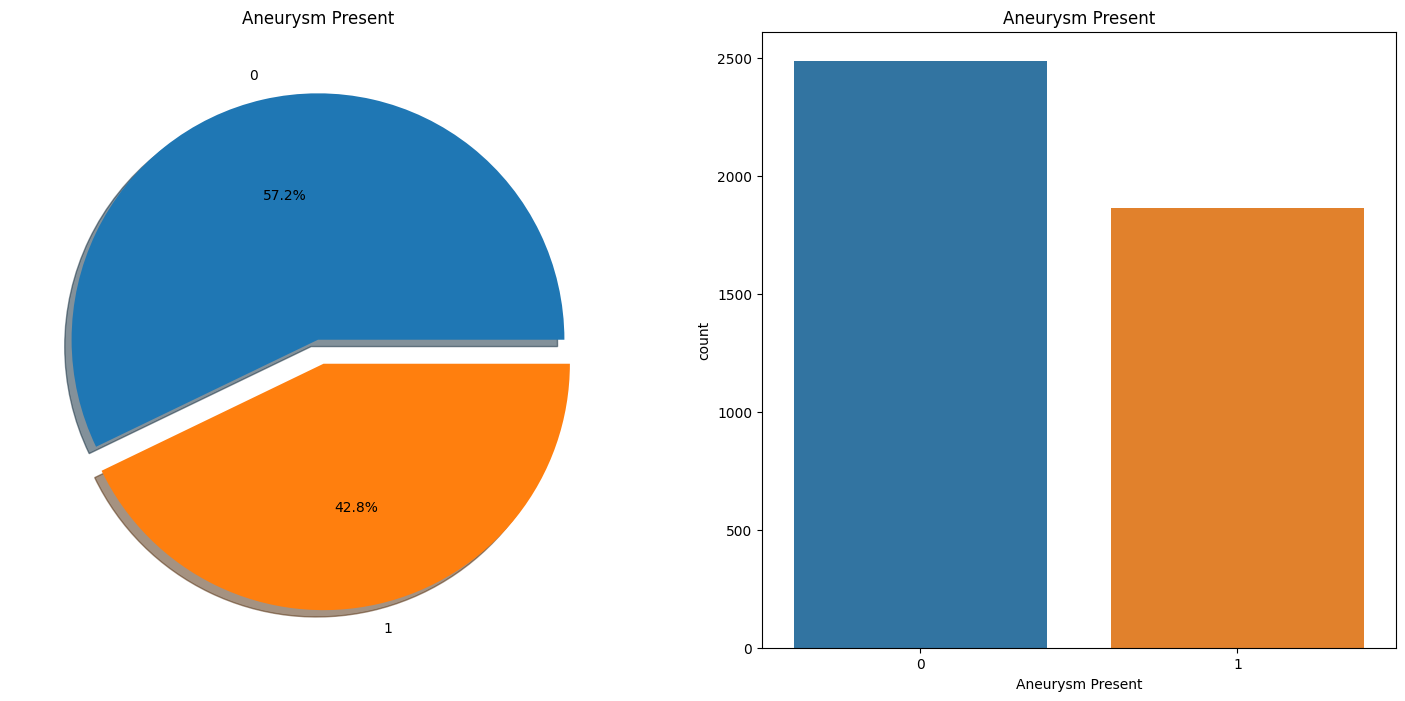

In [3]:
f,ax=plt.subplots(1,2,figsize=(18,8))
train['Aneurysm Present'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Aneurysm Present')
ax[0].set_ylabel('')
sns.countplot(x='Aneurysm Present', data=train)
ax[1].set_title('Aneurysm Present')
plt.show()

In [4]:
train.groupby(['PatientSex', 'Aneurysm Present'])['Aneurysm Present'].count()

PatientSex  Aneurysm Present
Female      0                   1599
            1                   1406
Male        0                    886
            1                    457
Name: Aneurysm Present, dtype: int64

In [5]:
pd.crosstab(train['Modality'], train['Aneurysm Present'], margins=True).style.background_gradient(cmap='summer_r')

Aneurysm Present,0,1,All
Modality,,,
CTA,835,973,1808
MRA,697,555,1252
MRI T1post,228,77,305
MRI T2,725,258,983
All,2485,1863,4348


In [6]:
train.loc[train['Aneurysm Present'] == 1, 'Modality']

2          CTA
8          CTA
9          MRA
10         CTA
12         CTA
         ...  
4337       CTA
4338    MRI T2
4339       CTA
4340       CTA
4347       CTA
Name: Modality, Length: 1863, dtype: object

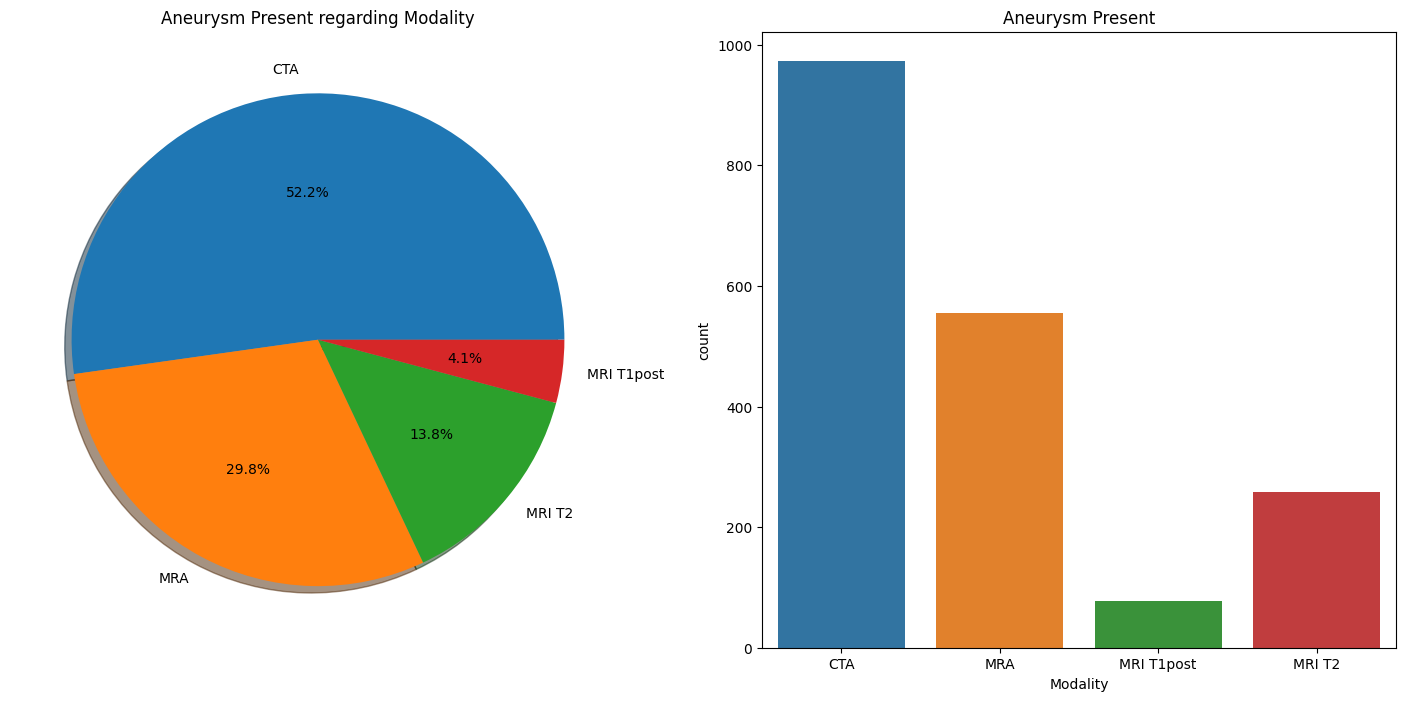

In [7]:
f,ax=plt.subplots(1,2,figsize=(18,8))
train.loc[train['Aneurysm Present'] == 1, 'Modality'].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Aneurysm Present regarding Modality')
ax[0].set_ylabel('')
sns.countplot(x=train.loc[train['Aneurysm Present'] == 1, 'Modality'])
ax[1].set_title('Aneurysm Present')
plt.show()

In [8]:
print('Oldest was of:',train['PatientAge'].max(),'Years')
print('Youngest was of:',train['PatientAge'].min(),'Years')
print('Average Age :',train['PatientAge'].mean(),'Years')

Oldest was of: 89 Years
Youngest was of: 18 Years
Average Age : 58.46688132474701 Years


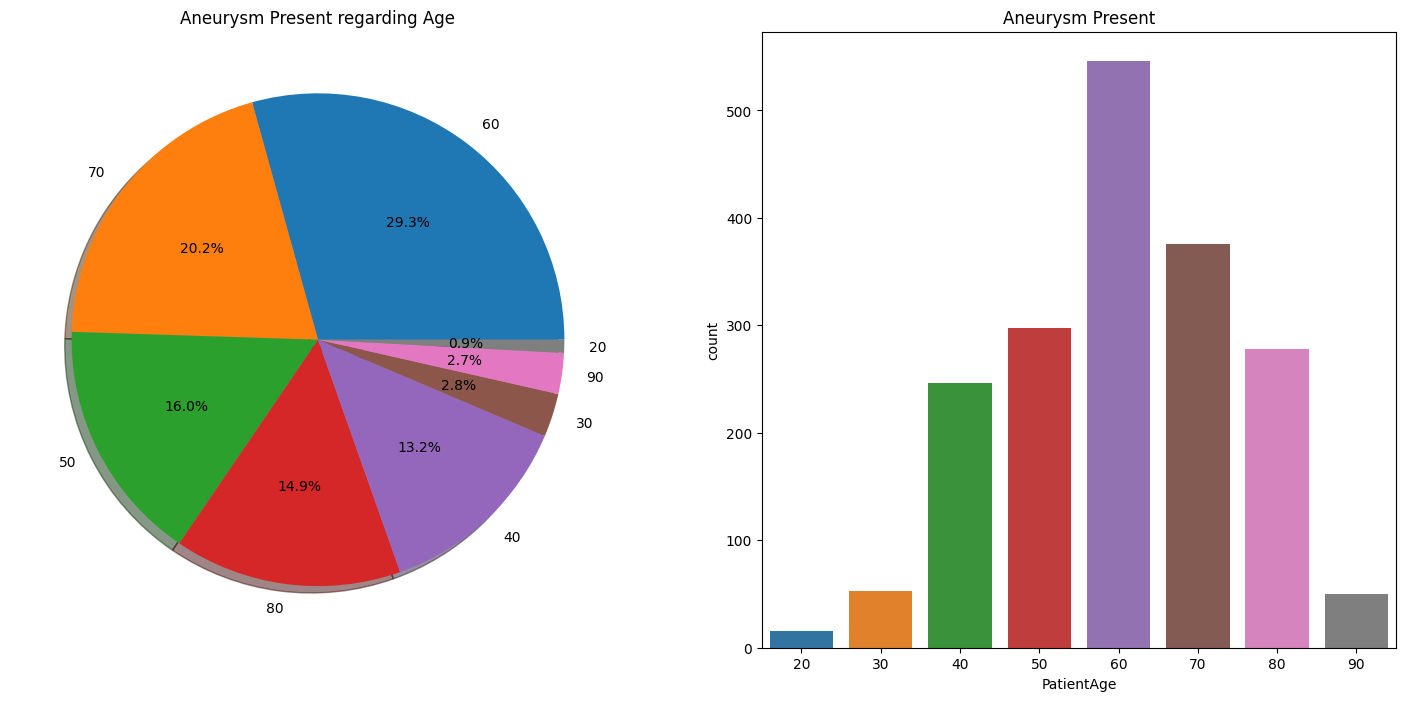

In [10]:
train['PatientAge'] = train['PatientAge'].apply(lambda x: round(x / 10) * 10)
# train['PatientAge'].unique()

f,ax=plt.subplots(1,2,figsize=(18,8))
train.loc[train['Aneurysm Present'] == 1, 'PatientAge'].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Aneurysm Present regarding Age')
ax[0].set_ylabel('')
sns.countplot(x=train.loc[train['Aneurysm Present'] == 1, 'PatientAge'])
ax[1].set_title('Aneurysm Present')
plt.show()

## Feature anaysis

In [11]:
# Replace categorical value into float value
train['PatientSex'] = train['PatientSex'].replace({'Female': '0', 'Male': '1'})

# Initalize the new column 'Category'
train['Category'] = None

In [12]:
columns = list(train.columns)
col = columns[4:17]

category = {c:i for c,i in zip(col, range(1,14))}
category['No aneurysm'] = 0
category

{'Left Infraclinoid Internal Carotid Artery': 1,
 'Right Infraclinoid Internal Carotid Artery': 2,
 'Left Supraclinoid Internal Carotid Artery': 3,
 'Right Supraclinoid Internal Carotid Artery': 4,
 'Left Middle Cerebral Artery': 5,
 'Right Middle Cerebral Artery': 6,
 'Anterior Communicating Artery': 7,
 'Left Anterior Cerebral Artery': 8,
 'Right Anterior Cerebral Artery': 9,
 'Left Posterior Communicating Artery': 10,
 'Right Posterior Communicating Artery': 11,
 'Basilar Tip': 12,
 'Other Posterior Circulation': 13,
 'No aneurysm': 0}

In [13]:
an_y = {}
for c,j, classe in zip(col,range(4, 18), range(1,14)):
    an_y[c] = (train.loc[train.iloc[:, j] == 1].index.to_list(), classe)

an_n = train.loc[train['Aneurysm Present'] == 0].index.to_list()

In [14]:
for (l, classe) in an_y.values():
    # print(classe)
    # print(type(l))
    for element in l:
        # print(element)
        train.at[element, 'Category'] = classe

for element in an_n:
    train.at[element, 'Category'] = 0

In [15]:
train = train.drop(columns=list(category.keys())[:13]+['Aneurysm Present'])
train.head()

,SeriesInstanceUID,PatientAge,PatientSex,Modality,Category
0,1.2.826.0.1.3680043.8.498.10004044428023505108...,60,0,MRA,0
1,1.2.826.0.1.3680043.8.498.10004684224894397679...,80,0,MRA,0
2,1.2.826.0.1.3680043.8.498.10005158603912009425...,60,1,CTA,13
3,1.2.826.0.1.3680043.8.498.10009383108068795488...,70,1,MRA,0
4,1.2.826.0.1.3680043.8.498.10012790035410518400...,50,0,MRA,0


## Aneurysm images visualization

### Series images

In [ ]:
import random as rd
from data.process import recup, coordinates, imshow

In [16]:
anr_pr = pd.read_csv("/kaggle/input/rsna-intracranial-aneurysm-detection/train_localizers.csv")

INIT_PATH = '/kaggle/input/rsna-intracranial-aneurysm-detection/series/'
N = len(anr_pr)

anr_pr['Category'] = None
for line in range(N):
    loc = anr_pr.iloc[line,3]
    anr_pr.at[line, 'Category'] = category[loc]
    
anr_pr.head()

,SeriesInstanceUID,SOPInstanceUID,coordinates,location,Category
0,1.2.826.0.1.3680043.8.498.10005158603912009425...,1.2.826.0.1.3680043.8.498.10775329348174902199...,"{'x': 258.3621186176837, 'y': 261.359900373599}",Other Posterior Circulation,13
1,1.2.826.0.1.3680043.8.498.10022796280698534221...,1.2.826.0.1.3680043.8.498.53868409774237283281...,"{'x': 194.87253141831238, 'y': 178.32675044883...",Right Middle Cerebral Artery,6
2,1.2.826.0.1.3680043.8.498.10023411164590664678...,1.2.826.0.1.3680043.8.498.24186535344744886473...,"{'x': 189.23979878597123, 'y': 209.19184886465...",Right Middle Cerebral Artery,6
3,1.2.826.0.1.3680043.8.498.10030095840917973694...,1.2.826.0.1.3680043.8.498.75217084841854214544...,"{'x': 208.2805049088359, 'y': 229.78962131837307}",Right Infraclinoid Internal Carotid Artery,2
4,1.2.826.0.1.3680043.8.498.10034081836061566510...,1.2.826.0.1.3680043.8.498.71237104731452368587...,"{'x': 249.86745590416498, 'y': 220.623044646393}",Anterior Communicating Artery,7


(512, 512)


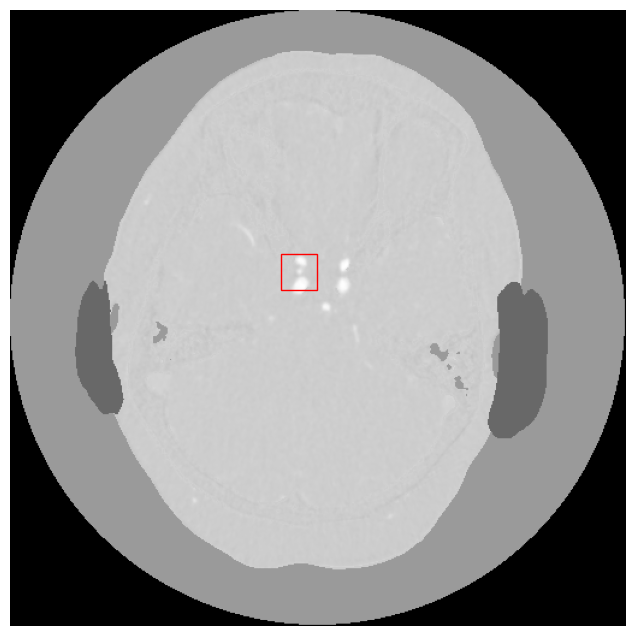

(512, 512)


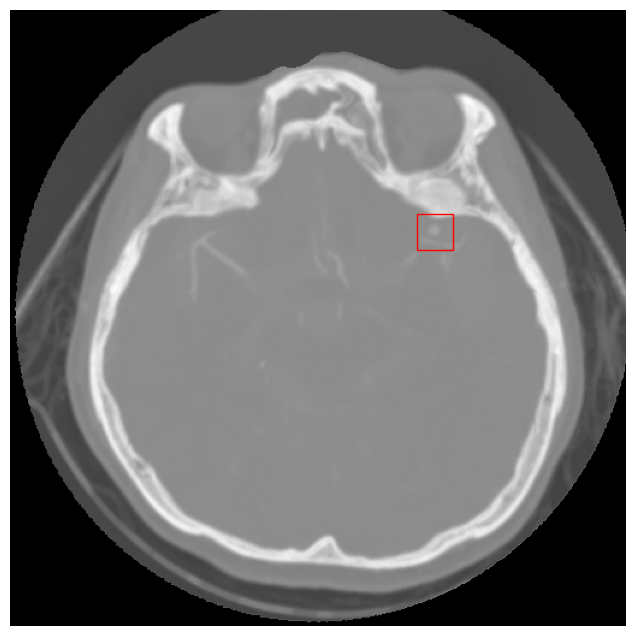

(512, 512)


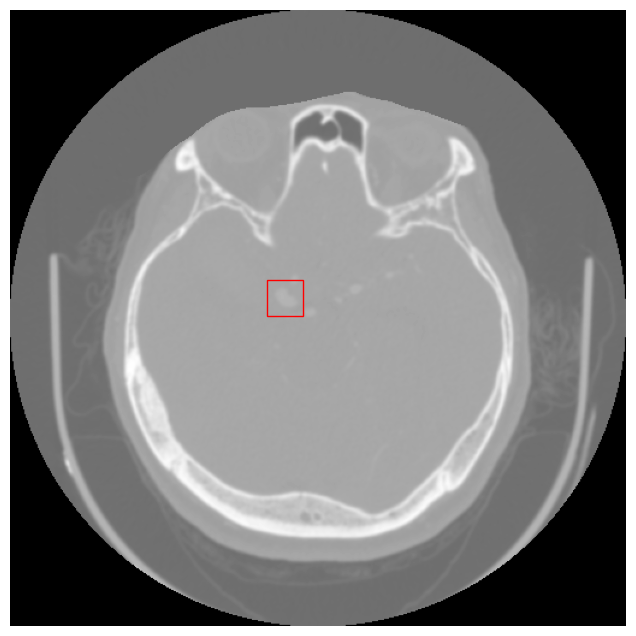

(512, 512)


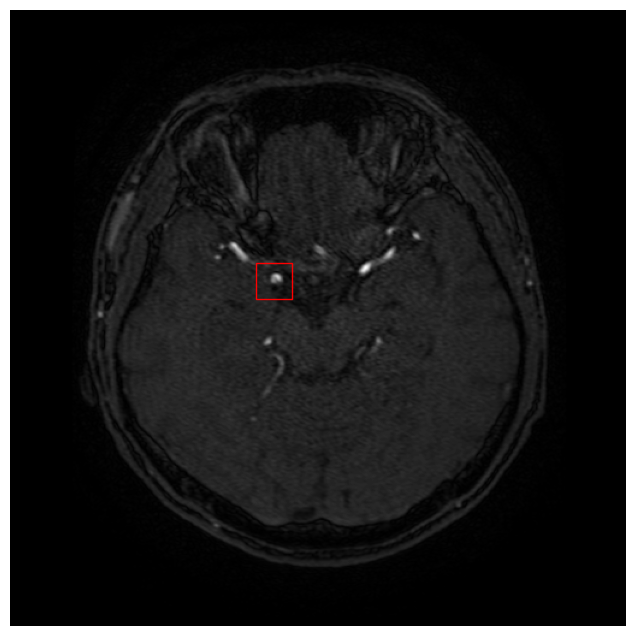

(512, 456)


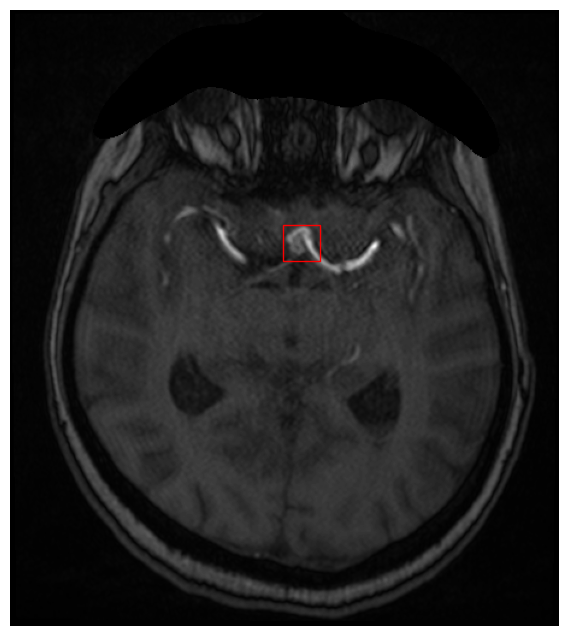

In [ ]:
height, width = 30, 30

l_rd = [rd.randint(0, 200) for _ in range(5)]

for k in l_rd:
    sr_id, img_id, crd = anr_pr.iloc[k,0], anr_pr.iloc[k,1], anr_pr.iloc[k,2]

    xy,hw = coordinates(crd, height, width)
    
    image = recup(INIT_PATH, sr_id, img_id)
    print(image.shape)
    imshow(image, hw)

### Segmentations

In [ ]:
import nibabel as nb
from data.process import segmentation

INIT_SEG_PATH = '/kaggle/input/rsna-intracranial-aneurysm-detection/segmentations/'

In [ ]:
example = '1.2.826.0.1.3680043.8.498.10035643165968342618460849823699311381'
seg1 = segmentation(INIT_SEG_PATH, example)
for i in range(5):
    plt.subplot(5, 5, i+1)
    plt.imshow(seg1[:,:,63+1])
    plt.gcf().set_size_inches(20, 20)
plt.show()

NameError: name 'segmentation' is not defined

In [47]:
ex_df = anr_pr.loc[anr_pr['SeriesInstanceUID'] == example]
ex_df

,SeriesInstanceUID,SOPInstanceUID,coordinates,location,Category
5,1.2.826.0.1.3680043.8.498.10035643165968342618...,1.2.826.0.1.3680043.8.498.30083322134992576720...,"{'x': 223.66020358711827, 'y': 225.3447011195274}",Right Anterior Cerebral Artery,9
6,1.2.826.0.1.3680043.8.498.10035643165968342618...,1.2.826.0.1.3680043.8.498.46752468449107005352...,"{'x': 289.2376764288231, 'y': 211.78100912436958}",Left Middle Cerebral Artery,5
7,1.2.826.0.1.3680043.8.498.10035643165968342618...,1.2.826.0.1.3680043.8.498.14504961303532677815...,"{'x': 232.88987039309842, 'y': 226.4305401310092}",Right Supraclinoid Internal Carotid Artery,4


(512, 512)


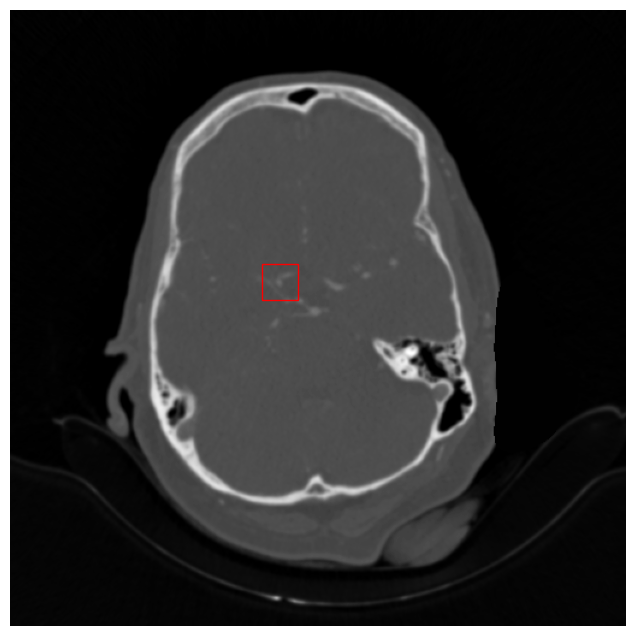

(512, 512)


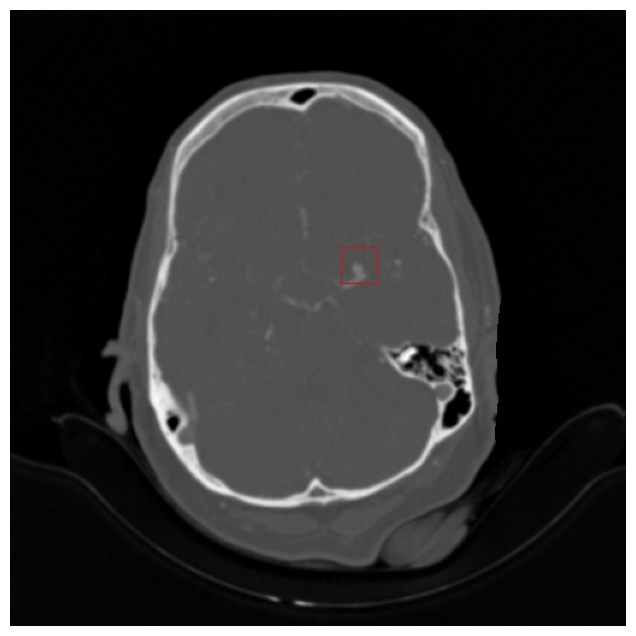

(512, 512)


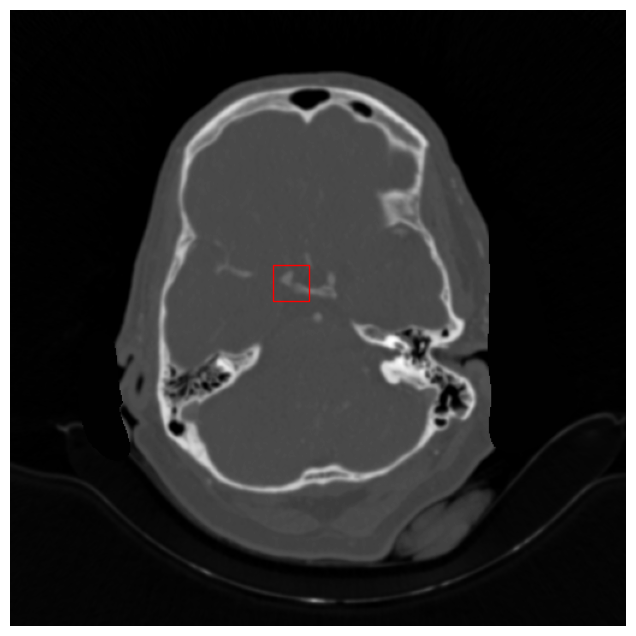

In [48]:
for k in list(ex_df.index):
    sr_id, img_id, crd = anr_pr.iloc[k,0], anr_pr.iloc[k,1], anr_pr.iloc[k,2]

    xy,hw = coordinates(crd)
    
    image = recup(sr_id, img_id)
    print(image.shape)
    imshow(image, hw)

## Images processing

In [ ]:
import cv2

SIZE = (256, 256)

### Dataset

# Model Architecture

In order to detect aneurysm presence in MRI samples, we need to examine each regions of those images. This is why, we opt for the ****image segmentation**** which enable this kind of scrutinizing. Among the various models and techniques of segmentation, we choose an ****U-Net**** architecture which stands out as a ****state of the art solution****.

In [ ]:
from model.unet import Unet
from model.method import train, evaluate, dice

## U-Net implementation

The encoding part of this archi correspond to a repetition of a module defined as a *Double Convolutions* and a *MaxPool*.

The decoding part 

### Training the model

In [ ]:
model = Unet()

# Prediction

In [ ]:
# def predict(series_path: str) -> pl.DataFrame | pd.DataFrame:
#     """Make a prediction."""
#     # --------- Replace this section with your own prediction code ---------
#     series_id = os.path.basename(series_path)
    
#     all_filepaths = []
#     for root, _, files in os.walk(series_path):
#         for file in files:
#             if file.endswith('.dcm'):
#                 all_filepaths.append(os.path.join(root, file))
#     all_filepaths.sort()
    
#     # Collect tags from the dicoms
#     tags = defaultdict(list)
#     tags['SeriesInstanceUID'] = series_id
#     global dcms
#     for filepath in all_filepaths:
#         ds = pydicom.dcmread(filepath, force=True)
#         tags['filepath'].append(filepath)
#         for tag in DICOM_TAG_ALLOWLIST:
#             tags[tag].append(getattr(ds, tag, None))
#         # The image is in ds.PixelData

#     # ... do some machine learning magic ...
#     predictions = pl.DataFrame(
#         data=[[series_id] + [0.5] * len(LABEL_COLS)],
#         schema=[ID_COL, *LABEL_COLS],
#         orient='row',
#     )
#     # ----------------------------------------------------------------------

#     if isinstance(predictions, pl.DataFrame):
#         assert predictions.columns == [ID_COL, *LABEL_COLS]
#     elif isinstance(predictions, pd.DataFrame):
#         assert (predictions.columns == [ID_COL, *LABEL_COLS]).all()
#     else:
#         raise TypeError('The predict function must return a DataFrame')

#     # ----------------------------- IMPORTANT ------------------------------
#     # You MUST have the following code in your `predict` function
#     # to prevent "out of disk space" errors. This is a temporary workaround
#     # as we implement improvements to our evaluation system.
#     shutil.rmtree('/kaggle/shared', ignore_errors=True)
#     # ----------------------------------------------------------------------
    
#     return predictions.drop(ID_COL)